In [5]:
# INSPECT TRAINED MODEL
# Load libraries
import os
import json
import random
from random import randint

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import cv2
import itertools
from tqdm import tqdm
import pydicom
from pydicom.pixel_data_handlers.util import apply_voi_lut
from skimage import exposure
from sklearn import preprocessing
from skimage.measure import find_contours
from matplotlib.patches import Polygon

import warnings
warnings.filterwarnings("ignore")

In [6]:
# Load data
DATA_DIR = "/media/daitran/Data/Kaggle/VinBigData"

TRAIN_DIR = os.path.join(DATA_DIR, "train")
TEST_DIR = os.path.join(DATA_DIR, "test")
TRAIN_CSV_DIR = os.path.join(DATA_DIR, "train.csv")
SS_CSV_DIR = os.path.join(DATA_DIR, "sample_submission.csv")

PREPROCESSED_TRAINING_IMAGE_FOLDER = '/home/daitran/Desktop/research/kaggle/VinBigData/train/512_jpg/'
resized_test_folder = '/home/daitran/Desktop/research/kaggle/VinBigData/test/'

orin_df = pd.read_csv(TRAIN_CSV_DIR)
orin_df = orin_df.query('class_id != 14')

# Load training dataframe .csv
training_df = pd.read_csv('/home/daitran/Desktop/git/chest_x_ray_abnormalities_detection/MaskRCNN_implementation/sample_df.csv', converters ={'EncodedPixels': eval, 'CategoryId': eval})
samples_df = training_df

In [7]:
# CONFIGURATIONS
from mrcnn.config import Config
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

NUM_CATS = 14
IMAGE_SIZE = 512


In [8]:
# Create Config 
class DiagnosticConfig(Config):
    NAME = "Diagnostic"
    NUM_CLASSES = NUM_CATS + 1 # +1 for the background class

    GPU_COUNT = 1
    IMAGES_PER_GPU = 10 #That is the maximum with the memory available on kernels

    BACKBONE = 'resnet50'

    IMAGE_MIN_DIM = IMAGE_SIZE
    IMAGE_MAX_DIM = IMAGE_SIZE
    IMAGE_RESIZE_MODE = 'none'

    POST_NMS_ROIS_TRAINING = 250
    POST_NMS_ROIS_INFERENCE = 150
    MAX_GROUNDTRUTH_INSTANCES = 5
    BACKBONE_STRIDES = [4, 8, 16, 32, 64]
    BACKBONESHAPE = (8, 16, 24, 32, 48)
    RPN_ANCHOR_SCALES = (8,16,24,32,48)
    ROI_POSITIVE_RATIO = 0.33
    DETECTION_MAX_INSTANCES = 300
    DETECTION_MIN_CONFIDENCE = 0.7


    STEPS_PER_EPOCH = int(len(samples_df)*0.8/IMAGES_PER_GPU)
    VALIDATION_STEPS = int(len(samples_df)/IMAGES_PER_GPU)-int(len(samples_df)*0.9/IMAGES_PER_GPU)

config = DiagnosticConfig()

In [9]:
# Create Inference Config
class InferenceConfig(config.__class__):
    # Run detection on one image at a time
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

config = InferenceConfig()
config.display()


Configurations:
BACKBONE                       resnet50
BACKBONESHAPE                  (8, 16, 24, 32, 48)
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        300
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  512
IMAGE_META_SIZE                27
IMAGE_MIN_DIM                  512
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              none
IMAGE_SHAPE                    [512 512   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL

In [10]:
# Extract class names
category_list = orin_df.class_name.unique()

In [11]:
# Create Mask RCNN formart dataset
class DiagnosticDataset(utils.Dataset):
    def __init__(self, df):
        super().__init__(self)

        # Add classes
        for i, name in enumerate(category_list):
            self.add_class("diagnostic", i+1, name)

        # Add images
        for i, row in df.iterrows():
            self.add_image("diagnostic",
                           image_id=row.name,
                           path= PREPROCESSED_TRAINING_IMAGE_FOLDER+str(row.image_id)+".jpg",
                           labels=row['CategoryId'],
                           annotations=row['EncodedPixels'],
                           height=row['Height'], width=row['Width'],
                           img_org_id = row.image_id)

    def image_reference(self, image_id):
        info = self.image_info[image_id]
        return info['path'], [category_list[int(x)] for x in info['labels']]

    def load_image(self, image_id):

        return cv2.imread(self.image_info[image_id]['path'])

    def load_mask(self, image_id):
        info = self.image_info[image_id]

        mask = np.zeros((IMAGE_SIZE, IMAGE_SIZE, len(info['annotations'])), dtype=np.uint8)
        labels = []
        for m, (annotation, label) in enumerate(zip(info['annotations'], info['labels'])):
            sub_mask = np.full(info['height']*info['width'], 0, dtype=np.uint8)

            annotation = [int(x) for x in annotation.split(' ')]

            for i, start_pixel in enumerate(annotation[::2]):
                sub_mask[start_pixel: start_pixel+annotation[2*i+1]] = 1

            sub_mask = sub_mask.reshape((info['height'], info['width']), order='F')
            sub_mask = cv2.resize(sub_mask, (IMAGE_SIZE, IMAGE_SIZE), interpolation=cv2.INTER_NEAREST)

            mask[:, :, m] = sub_mask
            labels.append(int(label)+1)
        return mask, np.array(labels)

In [12]:
# Load dataset
# Split with train = 80% samples and val = 10% and test = 10%
training_percentage = 0.8

training_set_size = int(training_percentage*len(samples_df))
validation_set_size = int((0.9-training_percentage)*len(samples_df))
test_set_size = int((0.9-training_percentage)*len(samples_df))

train_dataset = DiagnosticDataset(samples_df[:training_set_size])
train_dataset.prepare()

valid_dataset = DiagnosticDataset(samples_df[training_set_size:training_set_size+validation_set_size])
valid_dataset.prepare()

test_dataset = DiagnosticDataset(samples_df[training_set_size + validation_set_size:])
test_dataset.prepare()


In [13]:
# Show validation dataset information
print("Images: {}\nClasses: {}".format(len(valid_dataset.image_ids), valid_dataset.class_names))

Images: 3609
Classes: ['BG', 'Cardiomegaly', 'Aortic enlargement', 'Pleural thickening', 'ILD', 'Nodule/Mass', 'Pulmonary fibrosis', 'Lung Opacity', 'Atelectasis', 'Other lesion', 'Infiltration', 'Pleural effusion', 'Calcification', 'Consolidation', 'Pneumothorax']


In [14]:
# Call model
model = modellib.MaskRCNN(mode="inference", model_dir="",
                              config=config)

In [15]:
# Pretrained weight
model_path = '/home/daitran/Desktop/git/chest_x_ray_abnormalities_detection/MaskRCNN_implementation/server_weights/mask_rcnn_diagnostic_0009.h5'
model.load_weights(model_path, by_name=True)

In [16]:
# Display original
def display_test_result(dataset):
    image_id = random.choice(dataset.image_ids)
    print(image_id)
    print(dataset.class_names)

    # Display original Dicom

    # plot_bbox(img_id = dataset.image_info[image_id]['img_org_id'])

    # Display original in training form

    original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset, config, 
                               image_id, use_mini_mask=False)

    log("original_image", original_image)
    log("image_meta", image_meta)
    log("gt_class_id", gt_class_id)
    log("gt_bbox", gt_bbox)
    log("gt_mask", gt_mask)

    visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                                dataset.class_names, figsize=(8, 8))

    # Display test prediction

    results = model.detect([original_image], verbose=1)
    r = results[0]

    visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                                dataset.class_names, r['scores'])

26807
['BG', 'Cardiomegaly', 'Aortic enlargement', 'Pleural thickening', 'ILD', 'Nodule/Mass', 'Pulmonary fibrosis', 'Lung Opacity', 'Atelectasis', 'Other lesion', 'Infiltration', 'Pleural effusion', 'Calcification', 'Consolidation', 'Pneumothorax']
original_image           shape: (512, 512, 3)         min:    0.00000  max:  233.00000  uint8
image_meta               shape: (27,)                 min:    0.00000  max: 26807.00000  int64
gt_class_id              shape: (7,)                  min:    3.00000  max:   14.00000  int64
gt_bbox                  shape: (7, 4)                min:   60.00000  max:  406.00000  int32
gt_mask                  shape: (512, 512, 7)         min:    0.00000  max:    1.00000  uint8


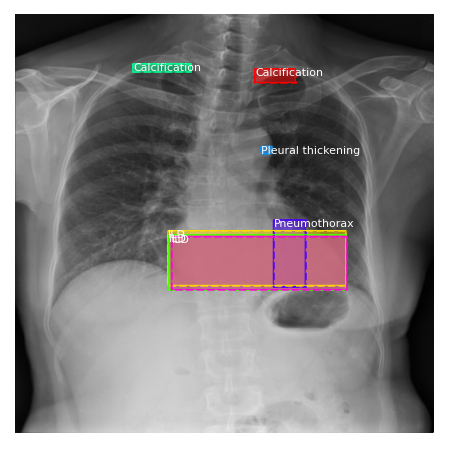

Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  233.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  129.10000  float64
image_metas              shape: (1, 27)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.06642  max:    1.00648  float32


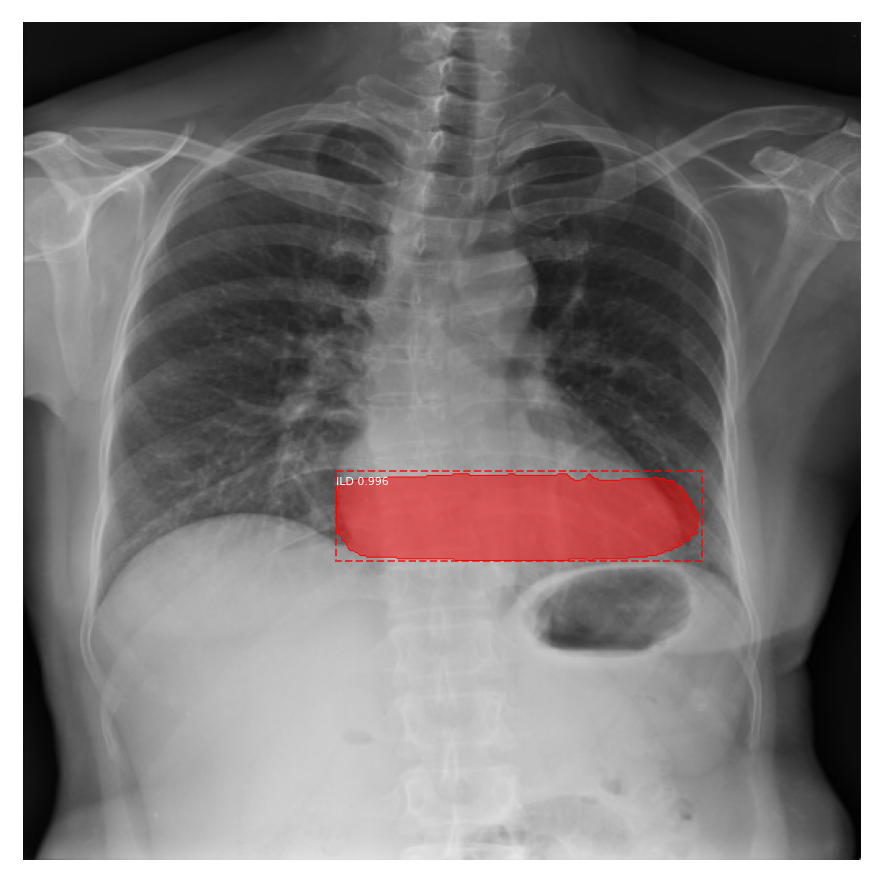

26760
['BG', 'Cardiomegaly', 'Aortic enlargement', 'Pleural thickening', 'ILD', 'Nodule/Mass', 'Pulmonary fibrosis', 'Lung Opacity', 'Atelectasis', 'Other lesion', 'Infiltration', 'Pleural effusion', 'Calcification', 'Consolidation', 'Pneumothorax']
original_image           shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
image_meta               shape: (27,)                 min:    0.00000  max: 26760.00000  int64
gt_class_id              shape: (22,)                 min:    1.00000  max:   14.00000  int64
gt_bbox                  shape: (22, 4)               min:   10.00000  max:  489.00000  int32
gt_mask                  shape: (512, 512, 22)        min:    0.00000  max:    1.00000  uint8


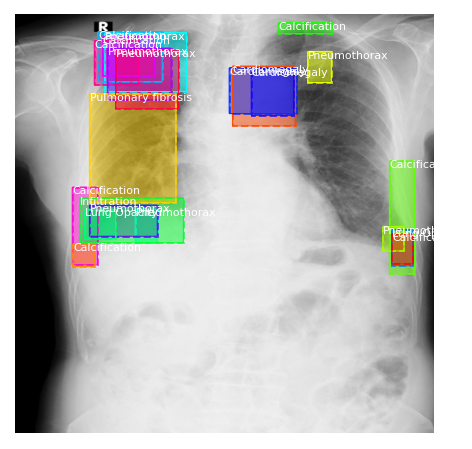

Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 27)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.06642  max:    1.00648  float32


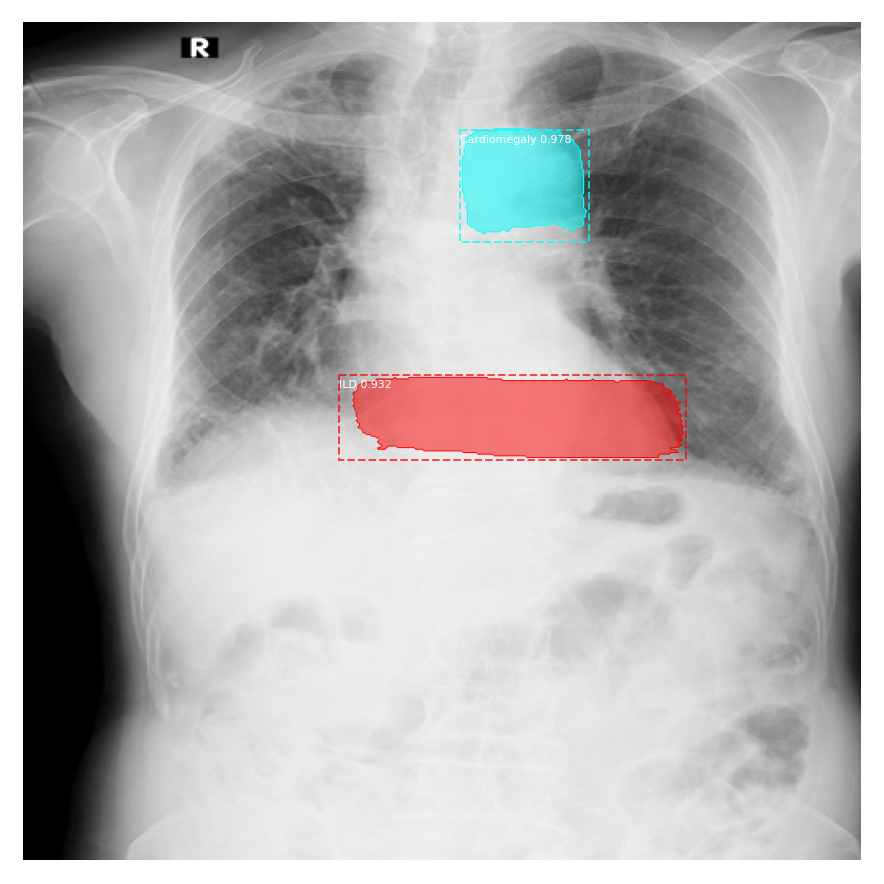

12523
['BG', 'Cardiomegaly', 'Aortic enlargement', 'Pleural thickening', 'ILD', 'Nodule/Mass', 'Pulmonary fibrosis', 'Lung Opacity', 'Atelectasis', 'Other lesion', 'Infiltration', 'Pleural effusion', 'Calcification', 'Consolidation', 'Pneumothorax']
original_image           shape: (512, 512, 3)         min:    0.00000  max:  222.00000  uint8
image_meta               shape: (27,)                 min:    0.00000  max: 12523.00000  int64
gt_class_id              shape: (7,)                  min:    1.00000  max:   12.00000  int64
gt_bbox                  shape: (7, 4)                min:   65.00000  max:  420.00000  int32
gt_mask                  shape: (512, 512, 7)         min:    0.00000  max:    1.00000  uint8


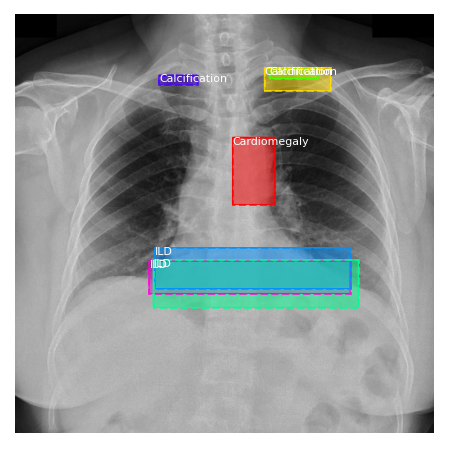

Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  222.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  118.10000  float64
image_metas              shape: (1, 27)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.06642  max:    1.00648  float32


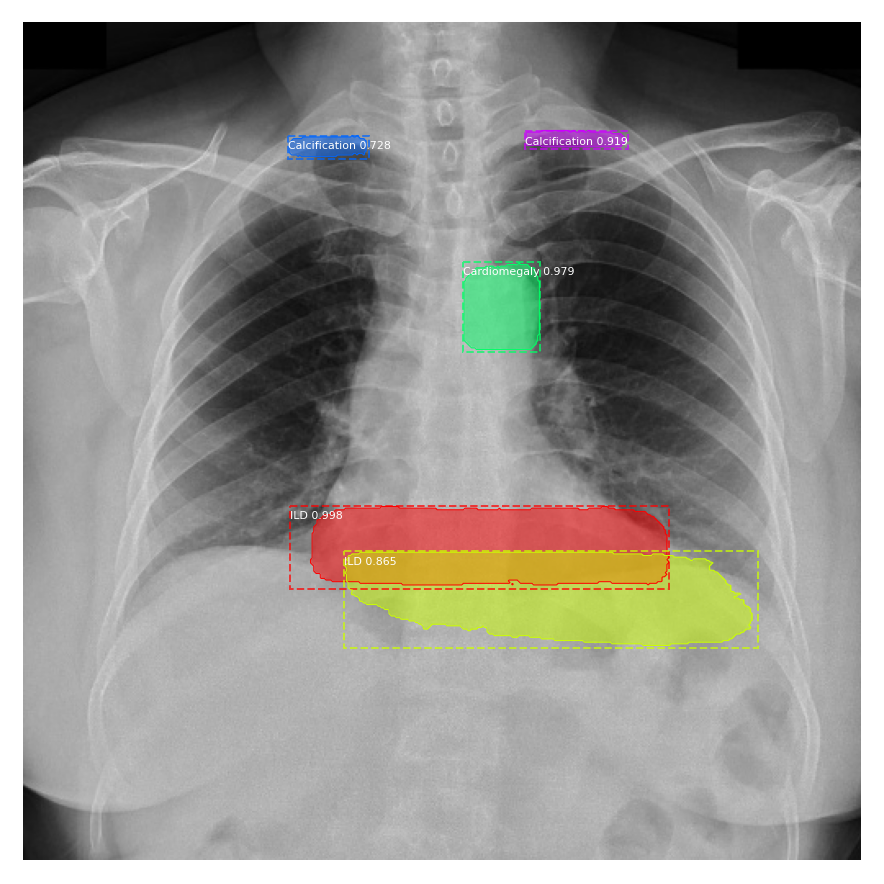

1854
['BG', 'Cardiomegaly', 'Aortic enlargement', 'Pleural thickening', 'ILD', 'Nodule/Mass', 'Pulmonary fibrosis', 'Lung Opacity', 'Atelectasis', 'Other lesion', 'Infiltration', 'Pleural effusion', 'Calcification', 'Consolidation', 'Pneumothorax']
original_image           shape: (512, 512, 3)         min:    0.00000  max:  250.00000  uint8
image_meta               shape: (27,)                 min:    0.00000  max: 1854.00000  int64
gt_class_id              shape: (6,)                  min:    1.00000  max:    8.00000  int64
gt_bbox                  shape: (6, 4)                min:   83.00000  max:  364.00000  int32
gt_mask                  shape: (512, 512, 6)         min:    0.00000  max:    1.00000  uint8


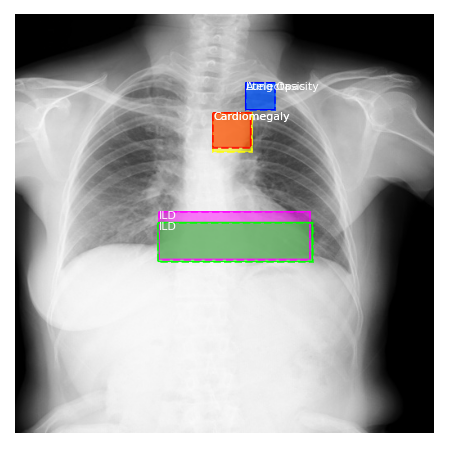

Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  250.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  146.10000  float64
image_metas              shape: (1, 27)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.06642  max:    1.00648  float32


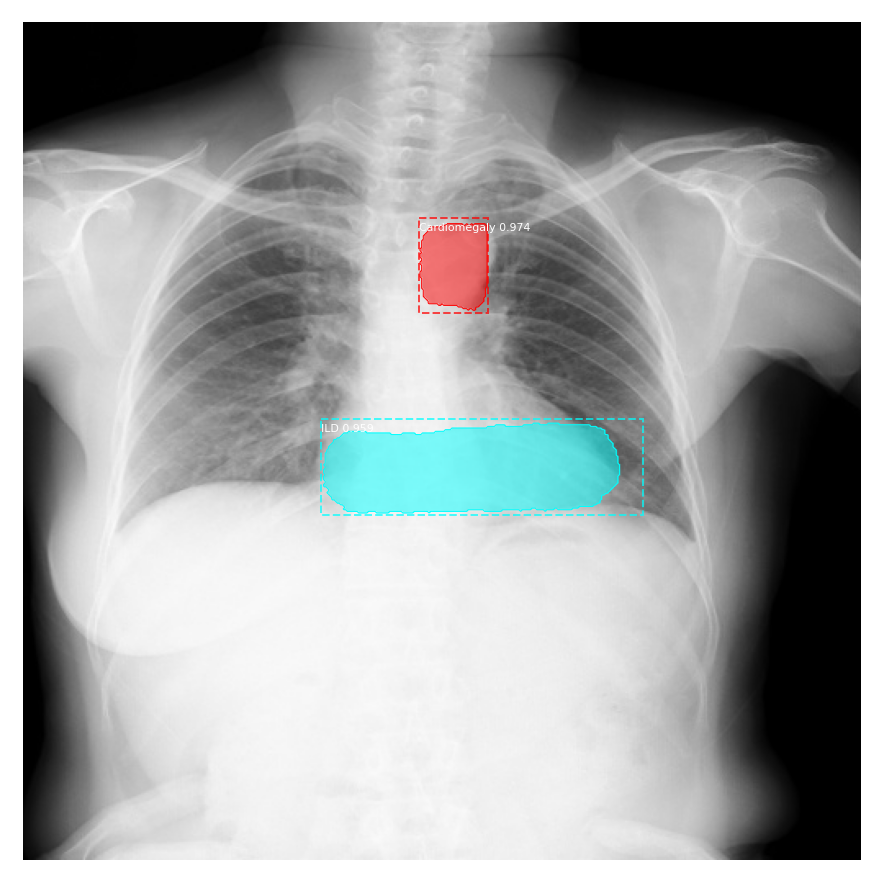

16515
['BG', 'Cardiomegaly', 'Aortic enlargement', 'Pleural thickening', 'ILD', 'Nodule/Mass', 'Pulmonary fibrosis', 'Lung Opacity', 'Atelectasis', 'Other lesion', 'Infiltration', 'Pleural effusion', 'Calcification', 'Consolidation', 'Pneumothorax']
original_image           shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
image_meta               shape: (27,)                 min:    0.00000  max: 16515.00000  int64
gt_class_id              shape: (4,)                  min:    1.00000  max:    4.00000  int64
gt_bbox                  shape: (4, 4)                min:  131.00000  max:  387.00000  int32
gt_mask                  shape: (512, 512, 4)         min:    0.00000  max:    1.00000  uint8


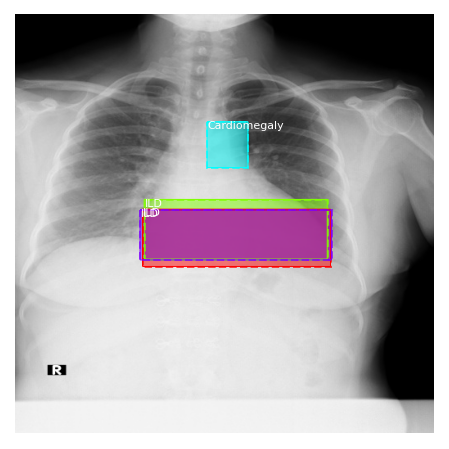

Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 27)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.06642  max:    1.00648  float32


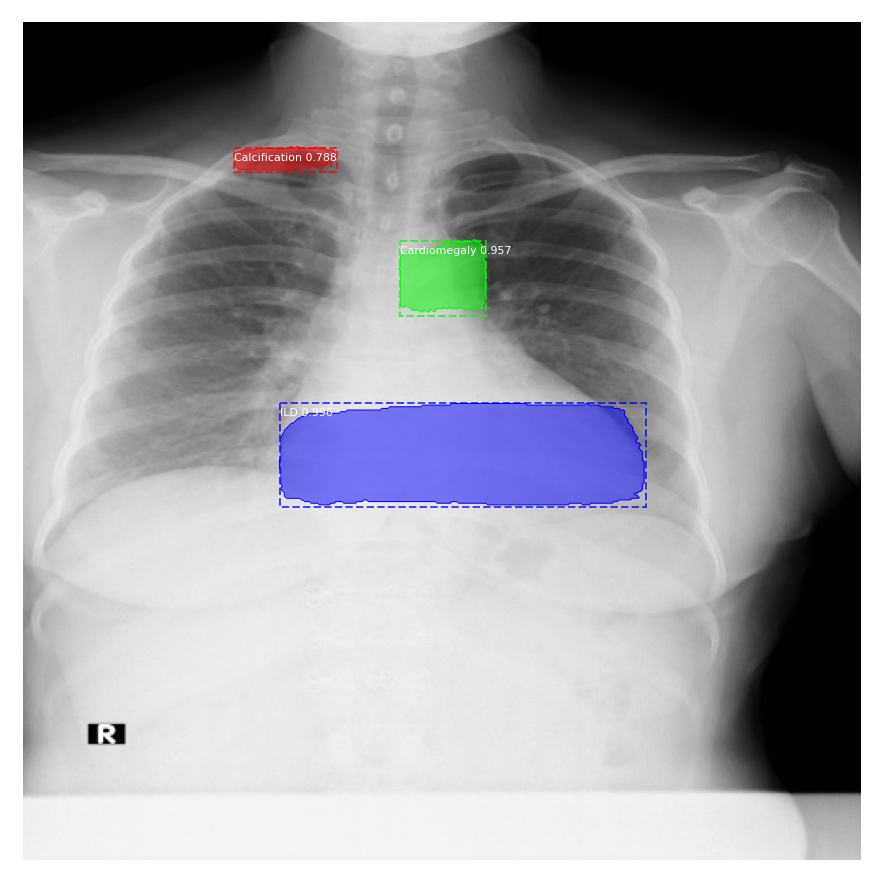

In [17]:
for _ in range(5):
    display_test_result(dataset = train_dataset)